# Mushroom Relevance Classifier
In this notebook, a binary classifier is trained to determine whether images in the given dataset are relevant or irrelevant. In the case of the dataset for the Mushroom Master model, this will mean filtering out irrelevant or noisy images such as diagrams, spore images, or other noisy data that is in the dataset. A small subset of around 250 images was chosen at random and manually labelled either 'relevant' or 'irrelevant'.


In [17]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input


base_dir = "/Users/remo/repos/mushroom_master/gathering-data/relevant_irrelevant_images"
train_dir = os.path.join(base_dir, "train")
val_dir   = os.path.join(base_dir, "validation")
test_dir = os.path.join(base_dir, "test")

img_height, img_width = 224, 224 
batch_size = 64

# Training data generator with augmentation
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,  
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary' 
)

# Validation data generator without augmentation
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)

Found 537 images belonging to 2 classes.
Found 114 images belonging to 2 classes.
Found 114 images belonging to 2 classes.


## Model Definition

A pre-trained mobilenetv2 model is used for its quick inference and training time. Given the significant intra-class variance between relevant and irrelvant images, due to how clearly different diagrams and spore images are from images of wild mushrooms, a particularly complex model architecture should not be necessary.

In [18]:
weights_file = 'mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_224_no_top.h5'

# %% [code]
base_model = MobileNetV2(weights=weights_file, include_top=False, input_shape=(img_height, img_width, 3))
base_model.trainable = False  # freeze the base model

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(1, activation='sigmoid')  # binary classification output
])


model.compile(optimizer=optimizers.Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

## Training
 
The model is trained over 50 epochs.

In [19]:

from tensorflow.keras.callbacks import EarlyStopping
epochs = 50  

early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=6,
    restore_best_weights=True,
    start_from_epoch=3,
)

history = model.fit(
    train_generator,
    epochs=epochs,
    callbacks=[early_stopping],
    validation_data=validation_generator
)

model.save('mushroom_model.keras')  

Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.5519 - loss: 0.7361 - val_accuracy: 0.9035 - val_loss: 0.3904
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.9298 - loss: 0.3101 - val_accuracy: 0.9035 - val_loss: 0.3591
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.9399 - loss: 0.2462 - val_accuracy: 0.9035 - val_loss: 0.3173
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.9336 - loss: 0.2507 - val_accuracy: 0.9035 - val_loss: 0.2651
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.9336 - loss: 0.2084 - val_accuracy: 0.9211 - val_loss: 0.2220
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.9500 - loss: 0.1556 - val_accuracy: 0.9298 - val_loss: 0.1928
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.9539 - loss: 0.1314 - val_accuracy: 0.9386 - val_loss: 0.1700
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.9610 - loss: 0.1345 - val_accuracy: 0.9386 - val_loss: 0.1523
Epoch 9/

## Evaluation

Visualize training history.


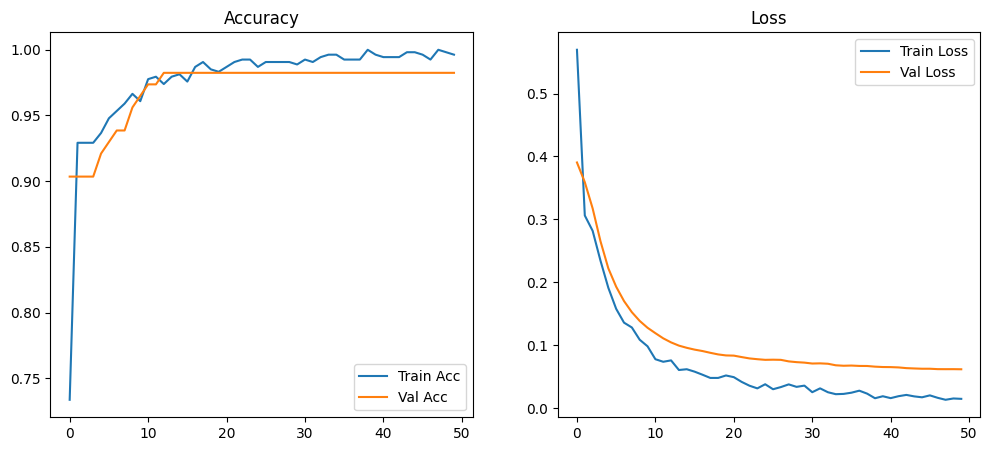

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.9889 - loss: 0.0325
Test Loss: 0.03732646256685257
Test Accuracy: 0.9912280440330505


In [20]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss")
plt.legend()

plt.show()

# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_generator)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)
